# Recurrent Neural Networks

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>
Updates by G. Durantin 2021

## Main activity : Time series forecasting (EEG data)

Today, we'll look at a simple example of time series forecasting. This family of algorithms can be used for a variety of prediction tasks, such as [predicting stock prices](https://arxiv.org/pdf/1911.13288.pdf) and [seizure prediction](https://www.sciencedirect.com/science/article/pii/S001048251830132X). We'll focus on the use of Recurrent Neural Networks in this context.

The data we'll use today is a set of EEG readings used to study seizures. You can find the data [here](https://physionet.org/content/chbmit/1.0.0/), and in the `data` directory there is a single patient recording `chb01_chb01_03.edf` which includes a seizure episode. We won't focus on seizure detection today but will instead try to predict neural activity.

These files are stored in the European Data Format, https://www.edfplus.info/. We'll use the python library `pyedflib` to read them. To use Colab, uncomment the following lines.

In [1]:
#!pip install pyedflib
#!wget https://github.com/SupaeroDataScience/deep-learning/blob/main/RNN/data/chb01_chb01_03.edf?raw=true
#!mkdir data 
#!mv chb01_chb01_03.edf?raw=true data/chb01_chb01_03.edf

In [2]:
# Imports
import os
import pyedflib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Reading files
file_name = os.path.join('data','chb01_chb01_03.edf')
f = pyedflib.EdfReader(file_name)

In [4]:
n = f.signals_in_file
labels = f.getSignalLabels()
print('%d different signals: %s' % (n, str(labels)))

23 different signals: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


The file we are reading contains 23 signals created using the data from electrodes on the scalp. 

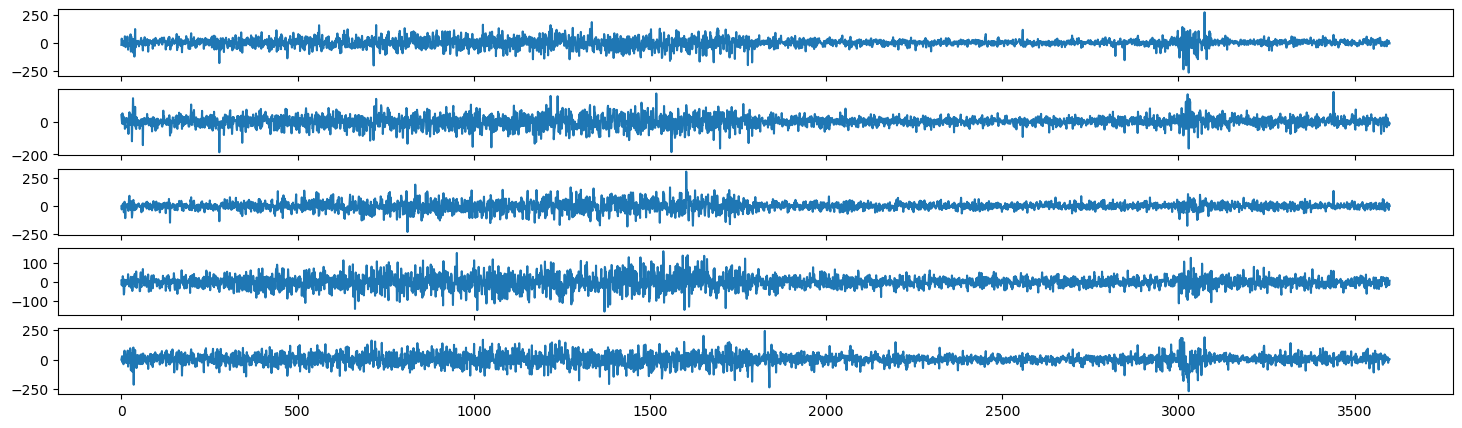

In [5]:
fig, axs = plt.subplots(5, sharex=True, figsize=(18,5))
for i in range(5):
    signal = f.readSignal(i)
    axs[i].plot(signal[::256])

As we can see, this single recording contains 23 different signals from different sensors placed on the scalp. We'll focus at predicting a single signal. Our first data processing step is normalizing the data. This is beneficial for recurrent neural network training, but does require domain knowledge. In this case, we know the physical limits of the sensors, so we can use that to normalize the data between $[-1, 1]$.

In [6]:
signal = f.readSignal(0)
signal = 2 * (signal - f.physical_min(0)) / (f.physical_max(0) - f.physical_min(0)) - 1.0

Another preparation often done with timeseries data is to check if it is **stationary**, ie if the mean and variance change over time. To do this, we'll use the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test). This test can be very costly to compute, so we'll downsample the data. There are 256 samples per second in this data, so we'll take one sample each second.

In [7]:
import statsmodels.api as sm
p_value = sm.tsa.stattools.adfuller(signal[::256])[1]
p_value

9.655290037083485e-30

The small value means that the timeseries **is stationary**. This isn't a necessary condition for LSTMs, but it will help training. When the timeseries is not stationary (`p_value > 0.05`), it's normal to instead predict the **difference** between timesteps, ie $$y_t - y_{t-1}$$ which can be calculated in numpy using `diff` and in pandas with `shift`.

Finally, we split our data into training and test sets, preserving order:

In [8]:
s_max = 1000
data = np.zeros((5, s_max))
for i in range(5):
    signal = f.readSignal(i)
    signal = 2 * (signal - f.physical_min(i)) / (f.physical_max(i) - f.physical_min(i)) - 1.0
    data[i, :] = signal[:s_max]
input = torch.from_numpy(data[:3, :-1])
target = torch.from_numpy(data[:3, 1:])
test_input = torch.from_numpy(data[3:, :-1])
test_target = torch.from_numpy(data[3:, 1:])

In [9]:
input

tensor([[-0.0222,  0.0002,  0.0002,  ...,  0.0266,  0.0183,  0.0159],
        [ 0.0491,  0.0002,  0.0002,  ...,  0.0261,  0.0330,  0.0369],
        [-0.0046,  0.0002,  0.0002,  ...,  0.0540,  0.0501,  0.0466]],
       dtype=torch.float64)

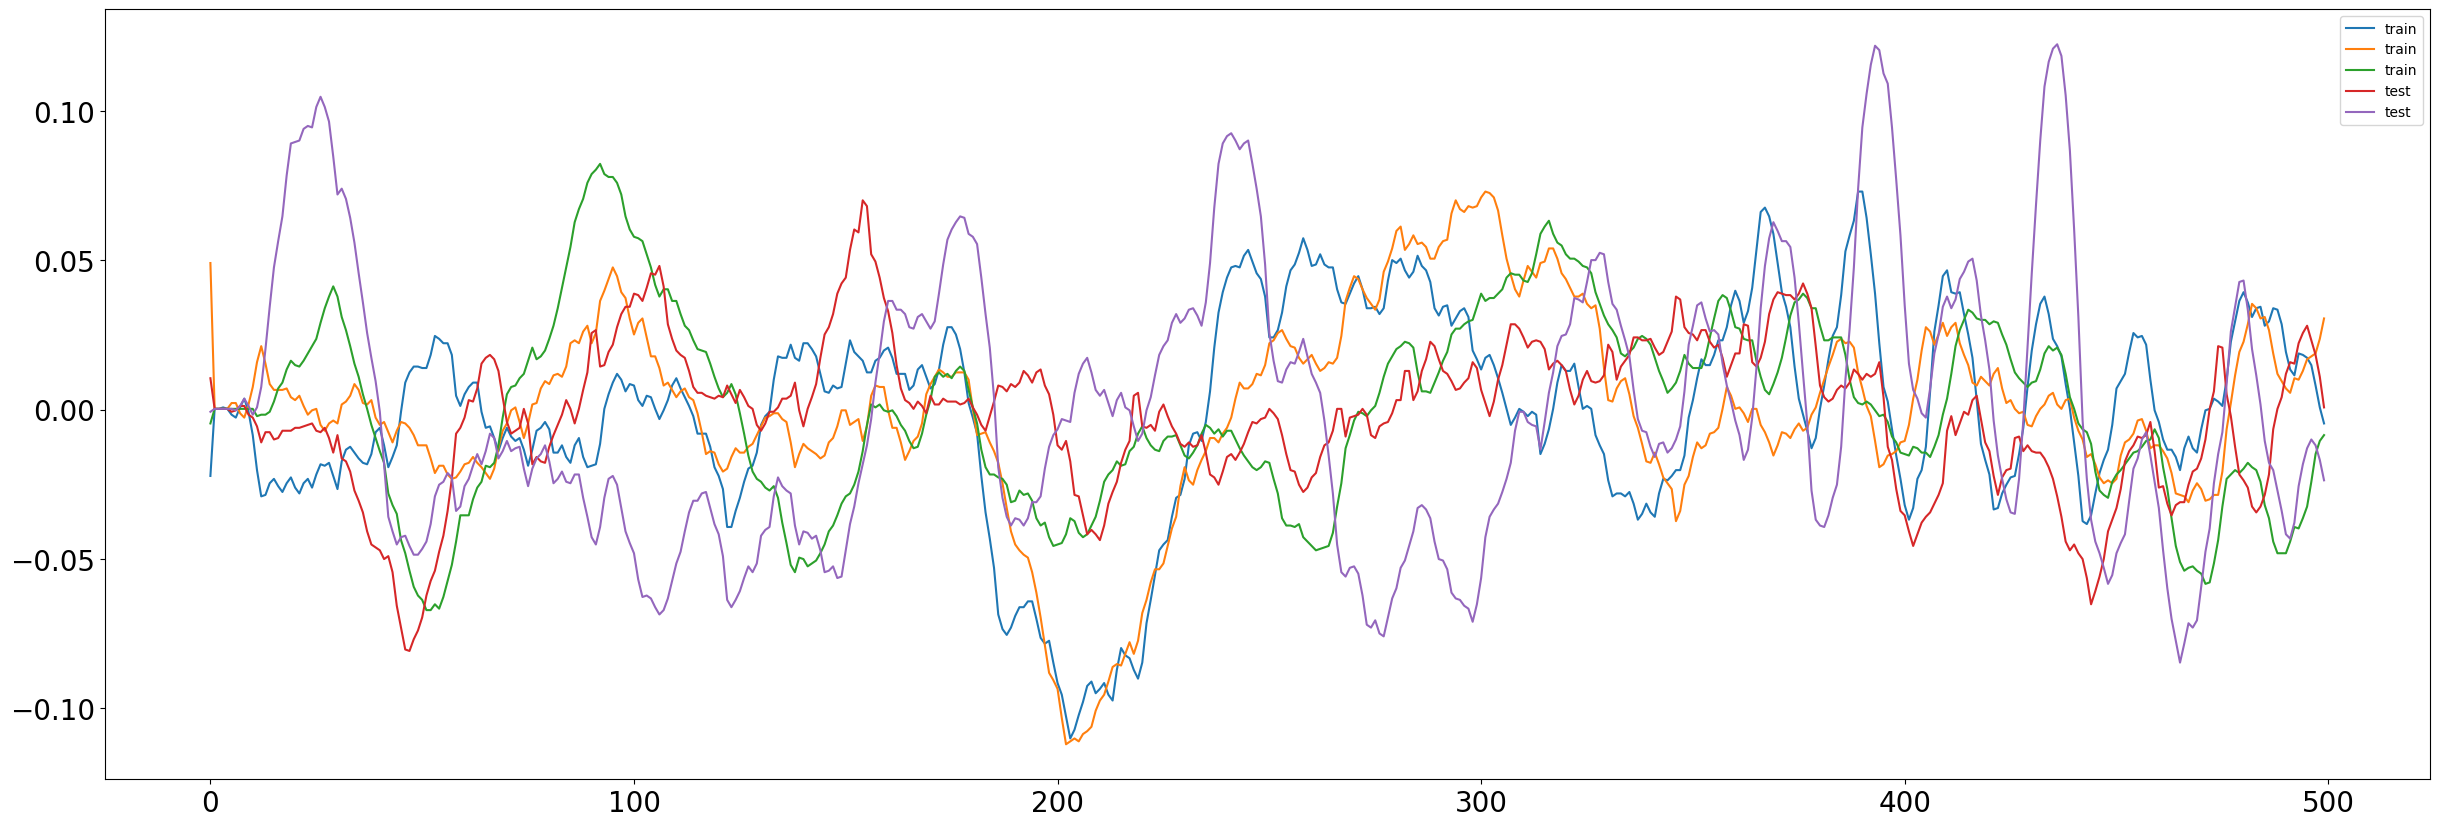

In [10]:
plt.figure(figsize=(30,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for i in range(3):
    plt.plot(input[i, :500], label='train')
for i in range(2):
    plt.plot(test_input[i, :500], label='test')
plt.legend();

We will start with a prediction which is
+ Univariate: we're using one signal to predict the future of that signal without considering other features. The opposite of this is multivariate, where multiple features are used in prediction (and multiple features can be simultaneously predicted)
+ 1-Step: we're predicting one step into the future, which can also be said as having a horizon of one sample. N-step or multi-step timeseries prediction is just an extension to this.

# Baselines

First we'll analyse the data and propose some simple baselines. We'll use **iterative prediction**, also known as walk-forward, to predict the next step at each timestep. The first baseline we'll use is called the naive baseline, which simply uses the previous value. We will start with a horizon of 1, meaning we have access to the previous timestep to predict the next one.

In [11]:
#Select the first EEG channel as the signal of interest
train_signal = input[0]
test_signal = target[0]
horizon = 1

In [12]:
# walk-forward validation
history = np.append(train_signal, np.zeros(len(test_signal)))
predictions = np.zeros(len(test_signal))
for i in range(len(test_signal)):
    t = len(train_signal) + i
    # make prediction
    predictions[i] = history[t-horizon] #naive baseline
    # observation
    history[t] = test_signal[i]

In [13]:
from sklearn.metrics import mean_squared_error
print("MSE of the naive baseline :",np.sqrt(mean_squared_error(predictions, test_signal)))

MSE of the naive baseline : 0.007971369099808836


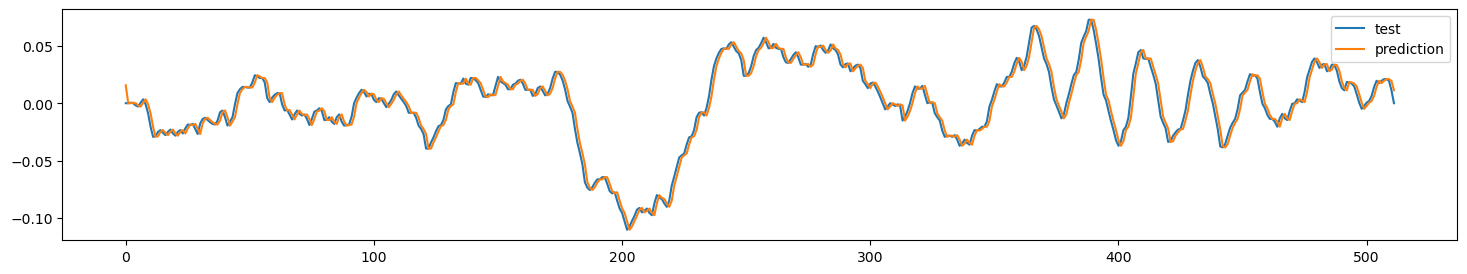

In [14]:
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test')
plt.plot(predictions[:512], label='prediction')
plt.legend();

For a horizon of 1, the naive baseline is pretty good. Let's see if the historical data beyond one timestep can be useful. We'll start with a windowed approach, using the average of the past `W=5` timesteps as our prediction.

In [15]:
history = np.append(train_signal, np.zeros(len(test_signal)))
predictions = np.zeros(len(test_signal))
w = 5
for i in range(len(test_signal)):
    t = len(train_signal) + i
    # make prediction
    predictions[i] = np.mean(history[t-w-horizon:t-horizon])
    # observation
    history[t] = test_signal[i]

MSE of the moving average baseline : 0.026034629906574396


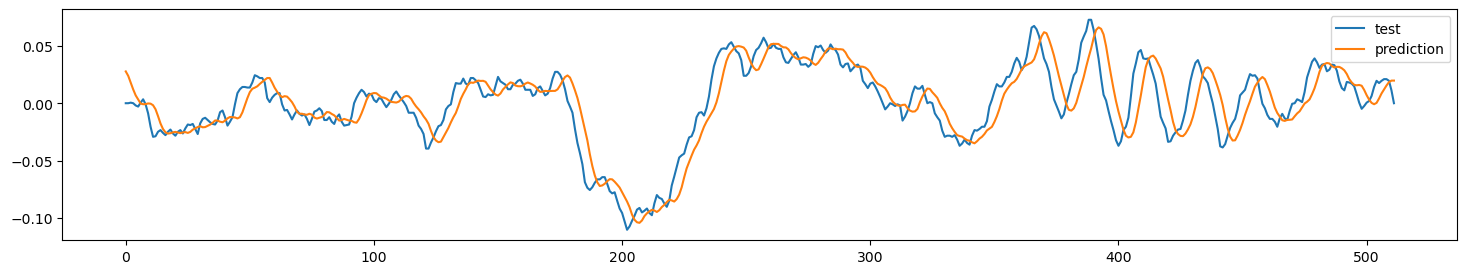

In [16]:
print("MSE of the moving average baseline :",np.sqrt(mean_squared_error(predictions, test_signal)))
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test')
plt.plot(predictions[:512], label='prediction')
plt.legend();

While this captures the general trend of some parts of the data, the naive baseline is still superior in terms of root mean squared error. Another approach is to exponentially decrease the dependency on past predictions, known as exponential smoothing. The rate by which we decrease past predictions is the parameter $\alpha$.

In [17]:
def exponential_smoothing(alpha):
    history = np.append(train_signal, np.zeros(len(test_signal)))
    predictions = np.zeros(len(test_signal))
    for i in range(len(test_signal)):
        t = len(train_signal) + i
        # make prediction
        if i == 0:
            predictions[i] = history[t-horizon]
        else:    
            predictions[i] = alpha * history[t-horizon] + (1 - alpha) * predictions[i-horizon]
        # observation
        history[t] = test_signal[i]
    return predictions

In [18]:
predictions_01 = exponential_smoothing(0.1)
print("MSE of the EMA baseline with alpha=0.1 :",np.sqrt(mean_squared_error(predictions_01, test_signal)))

MSE of the EMA baseline with alpha=0.1 : 0.027623053683837103


In [19]:
predictions_05 = exponential_smoothing(0.5)
print("MSE of the EMA baseline with alpha=0.5 :",np.sqrt(mean_squared_error(predictions_05, test_signal)))

MSE of the EMA baseline with alpha=0.5 : 0.0136288867041948


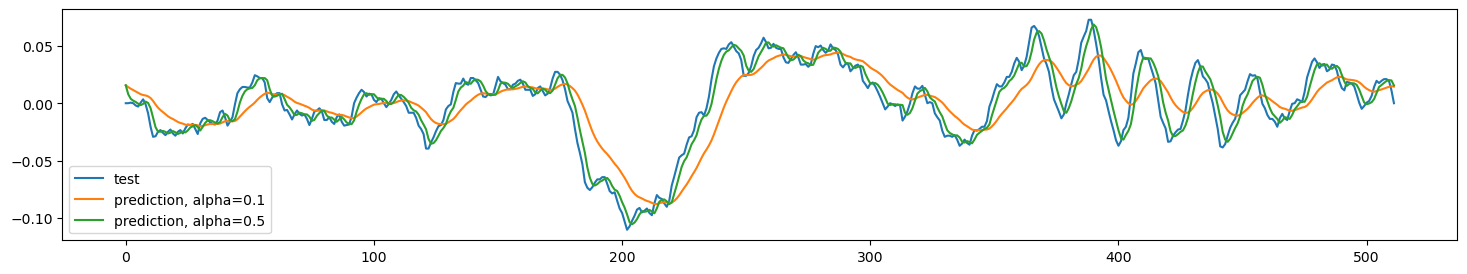

In [21]:
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test')
plt.plot(predictions_01[:512], label='prediction, alpha=0.1')
plt.plot(predictions_05[:512], label='prediction, alpha=0.5')
plt.legend();

While lower alpha values help predict the general trend of our data, their RMSE is worse than using very short history. So **for this EEG data, we're still struggling to make good use of the historical data to predict future data**. Instead of a single parameter for history decay, we'll instead use a recurrent neural network to inform our reliance on memory for prediction, and optimize the network parameters using Stochastic Gradient Descent.

# Recurrent Neural Networks

A simple recurrent neural network layer is very similar to a fully-connected feed-forward neural network layer; it has a set of weights $W_x$ mapping the previous layer $x$ to each neuron of the recurrent layer, a bias term for each neuron, and an activation function. However, a recurrent neural network also has state; specifically, each neuron connects to every other neuron in the same layer with a time delay of 1. This means that a recurrent neural network layer has a second weight matrix $W_s$ of size $n$x$n$, where $n$ is the number of neurons in the recurrent layer.

$s_t = \tanh(W_{x} x + b_{x}  +  W_{s} s_{t-1} + b_{s})$

One way to consider these recurrent connections is by representing the previous activation functions of the recurrent layer as a hidden state, and using that hidden state as input to the network:

<img src="img/rnn.png">

Let's first observe the behavior of a single RNN layer using the `RNNCell` class from PyTorch. The documentation is [here](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html).

In [22]:
rnn = nn.RNNCell(1, 10)

In [23]:
input_signal = torch.randn(1, 1)
hidden_state = torch.zeros(1, 10)
input_signal, hidden_state

(tensor([[0.1101]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [24]:
hidden_state = rnn(input_signal, hidden_state)
hidden_state

tensor([[ 0.3044, -0.0110,  0.3316,  0.1062,  0.4054, -0.4307, -0.2833, -0.2693,
         -0.1225, -0.2114]], grad_fn=<TanhBackward0>)

As we can see, the output of the `RNNCell` is the new hidden state. In order to predict the next value, we'll use a `Linear` model to map from this hidden state to a single output value.

In [25]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn1 = nn.RNNCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # predict over the different signals
        outputs = []
        for input_t in input.split(1, dim=1):
            hidden = self.rnn1(input_t, hidden)
            output = self.linear(hidden)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs, hidden
    
    def init_hidden(self):
        return torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)

MSE of the RNN prediction with random weights : 0.04879365499311831


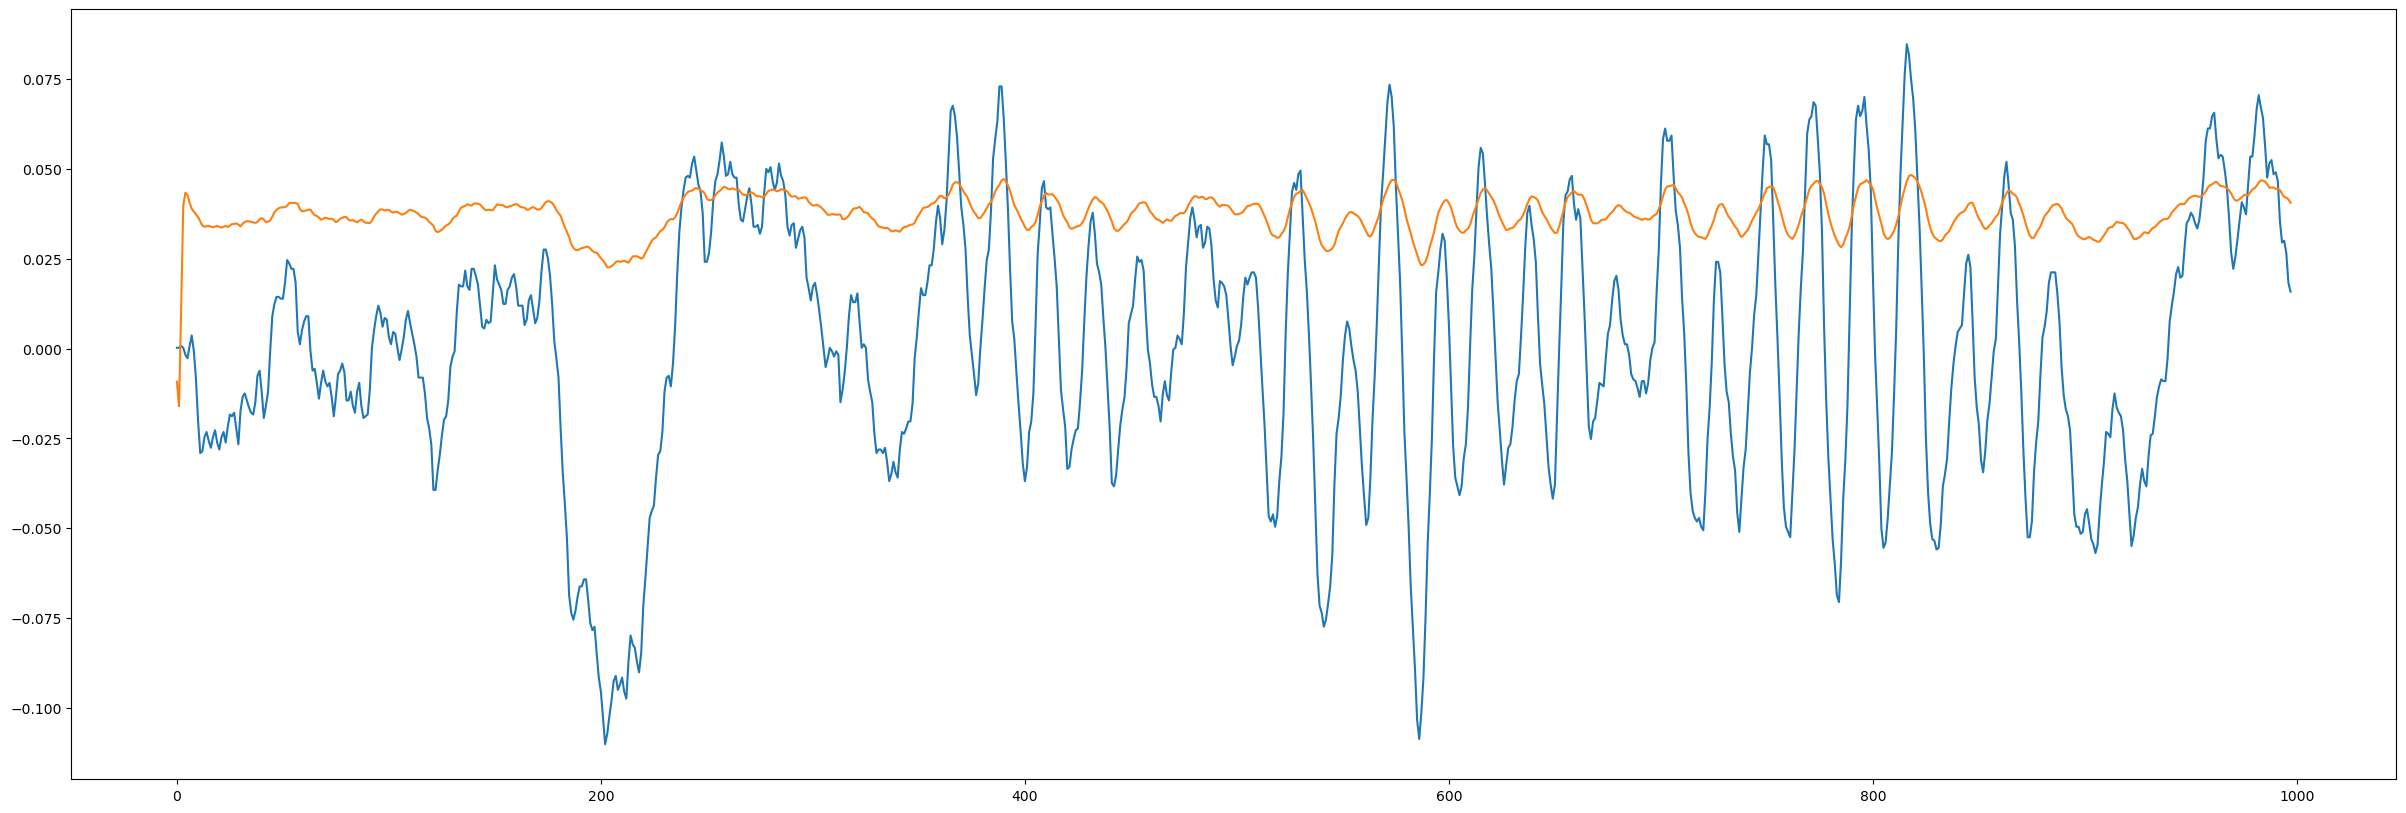

In [65]:
#initialize RNN and its initial recurrent state
n_hidden = 16
rnn = RNN(1, n_hidden, 1).double()
hidden = rnn.init_hidden()

#run a prediction over the signal
with torch.no_grad():
    output, _ = rnn(input, hidden)
    y = output.detach().numpy()
    
print("MSE of the RNN prediction with random weights :",np.sqrt(mean_squared_error(input[0, 1:], y[0, :-1])))
plt.figure(figsize=(30,10))
plt.plot(input[0, 1:], label='real')
plt.plot(y[0, :-1], label='prediction');

This isn't very convincing, but remember that it is random weights. We'll soon get to training, but first let's increase the lookahead of our recurrent neural network. We'll try to predict 5 timesteps ahead.

The main difference with recurrent neural networks is that they depend on the previous state for the current state's computation. Instead of simply prediction $Y = f(x)$ as in feed-forward neural networks, recurrent networks do $Y_1 = f(x_1, f(x_0))$. Here's what an example "unrolled" RNN looks like, where the hidden state is carried over to next timestep.

<img src="img/unrolled.png">

<div class="alert alert-success">
Exercise 1
    
Include a look-ahead of `future` timesteps in your RNN model by completing the class below. Make sure to continuously update the `hidden` state.
</div>

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn1 = nn.RNNCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden,future=0):
        outputs = []
        for input_t in input.split(1, dim=1):
            hidden = self.rnn1(input_t, hidden)
            output = self.linear(hidden)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs, hidden
    
    def init_hidden(self):
        return torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)

In [69]:
# %load solutions/1_future.py
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn1 = nn.RNNCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, future=0):
        # predict over the different signals
        outputs = []
        for input_t in input.split(1, dim=1):
            hidden = self.rnn1(input_t, hidden)
            output = self.linear(hidden)
            outputs += [output]
        for _ in range(future):# if we should predict the future
            hidden = self.rnn1(output, hidden)
            output = self.linear(hidden)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs, hidden
    
    def init_hidden(self):
        return torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)

In [70]:
output.size()

torch.Size([3, 999])

MSE of the RNN prediction with random weights : 0.05654067301984106


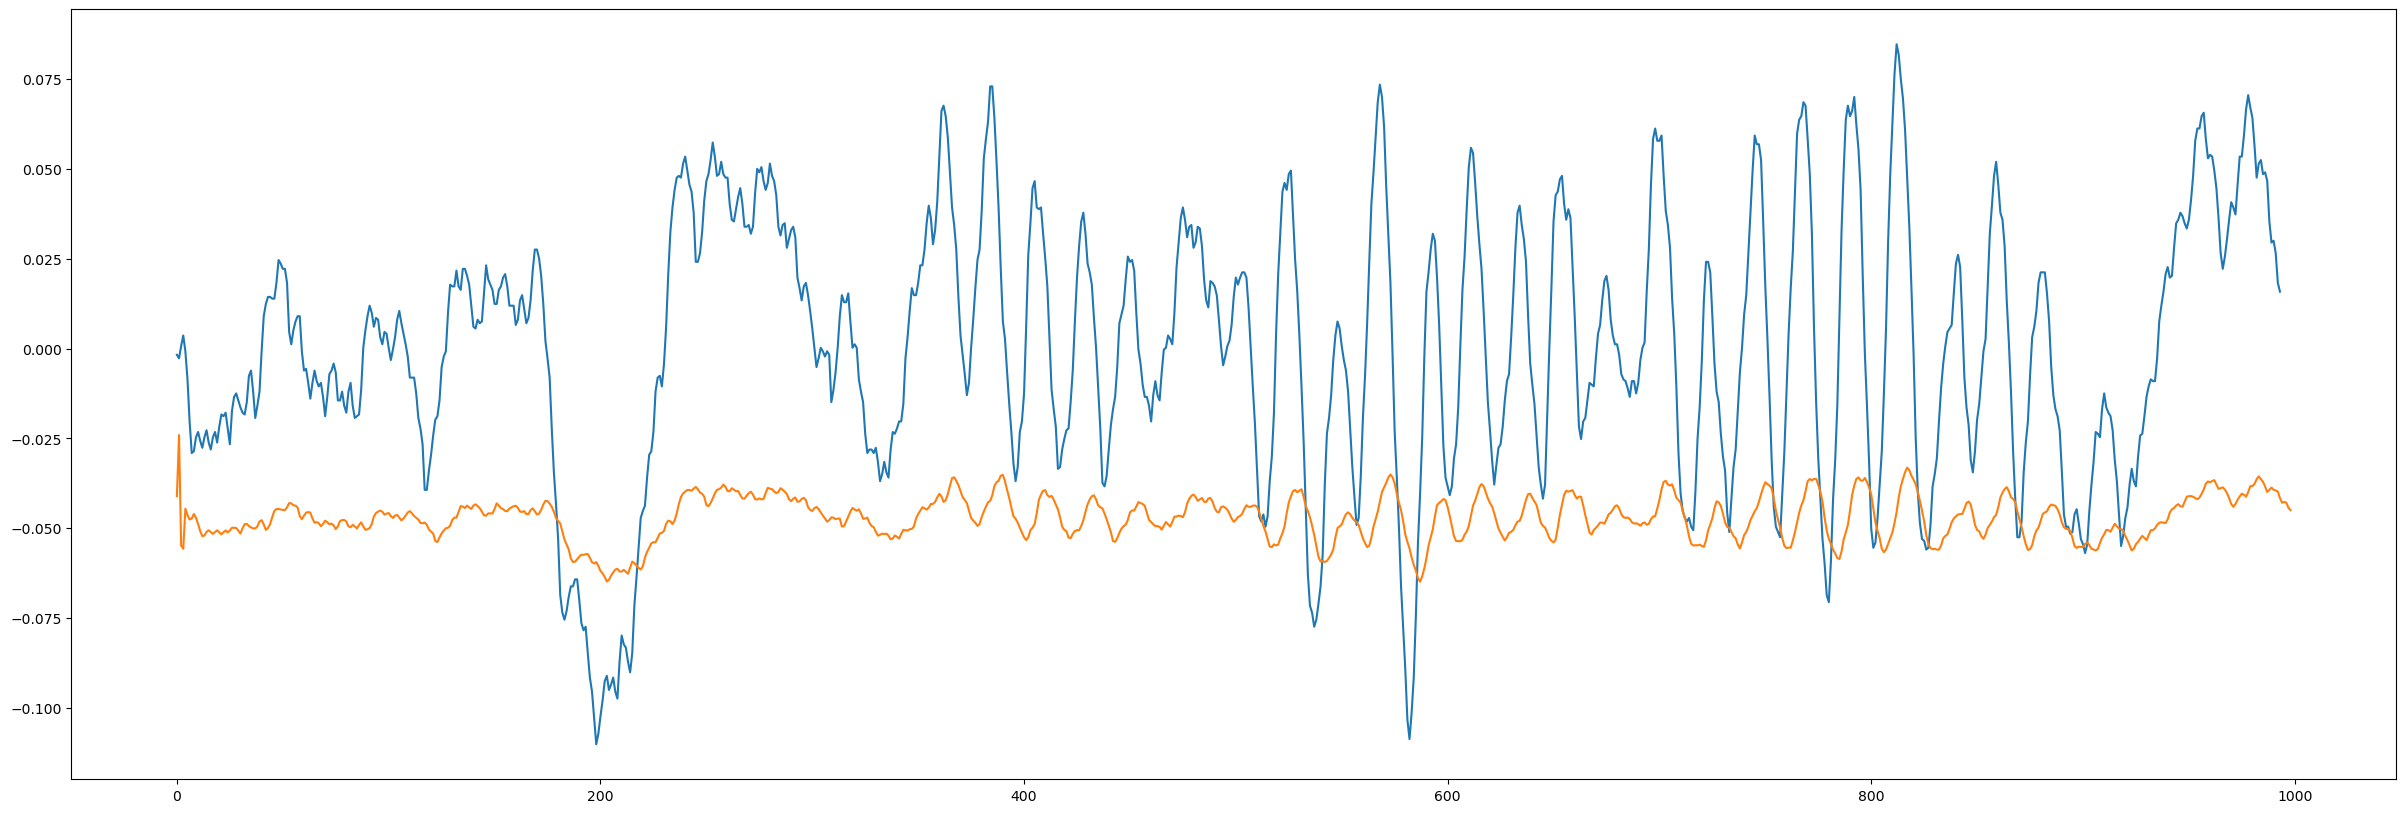

In [71]:
rnn = RNN(1, n_hidden, 1).double()
hidden=rnn.init_hidden()

f = 5
with torch.no_grad():
    output, _ = rnn(input, hidden, future=f)
    y = output.detach().numpy()

print("MSE of the RNN prediction with random weights :",np.sqrt(mean_squared_error(input[0, f:], y[0, f:-f])))
plt.figure(figsize=(30,10))
plt.plot(input[0, f:], label='real')
plt.plot(y[0, :-f], label='prediction');

## Backpropagation through time

Our network doesn't do very well, but it's using random weights. In order to train it, we'll need to calcuate the gradient throughout the iterative process. This is known as **backpropagation through time**, and it relies on the computation of not just the current timestep, but all previous timesteps as well.

<img src="img/bptt.png">

In [75]:
rnn = RNN(1, n_hidden, 1).double()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(rnn.parameters(), lr=0.8) # limited memory BFGS

In [76]:
# training step through all data
def closure():
    optimizer.zero_grad()
    hidden=rnn.init_hidden()
    out, hidden = rnn(input,hidden, future=5)
    loss = criterion(out[:, 5:-5], target[:, 5:])
    print('loss:', loss.item())
    loss.backward()
    return loss

In [82]:
optimizer.step(closure)

loss: 3.289836607254558e-05
loss: 2.9148275465392317e-05
loss: 2.553027713423598e-05
loss: 2.5234361342395996e-05
loss: 2.5190139816519007e-05
loss: 2.515921491038747e-05
loss: 2.515231870153106e-05
loss: 2.5139375752424168e-05
loss: 2.5109204048641624e-05
loss: 2.5033926435238405e-05
loss: 2.481496908701428e-05
loss: 2.5990645018828124e-05
loss: 2.376723076140864e-05
loss: 2.2850829114268574e-05
loss: 2.159094445567287e-05
loss: 1.2392061896220798
loss: 0.0028653392853213414
loss: 0.00202685310298157
loss: 0.00013574426427595128
loss: 2.5268178503242226e-05


tensor(3.2898e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [83]:
hidden=rnn.init_hidden()
with torch.no_grad():
    output, hidden = rnn(input,hidden)
    y = output.detach().numpy()

MSE of the RNN prediction after training : 0.016719924321743854


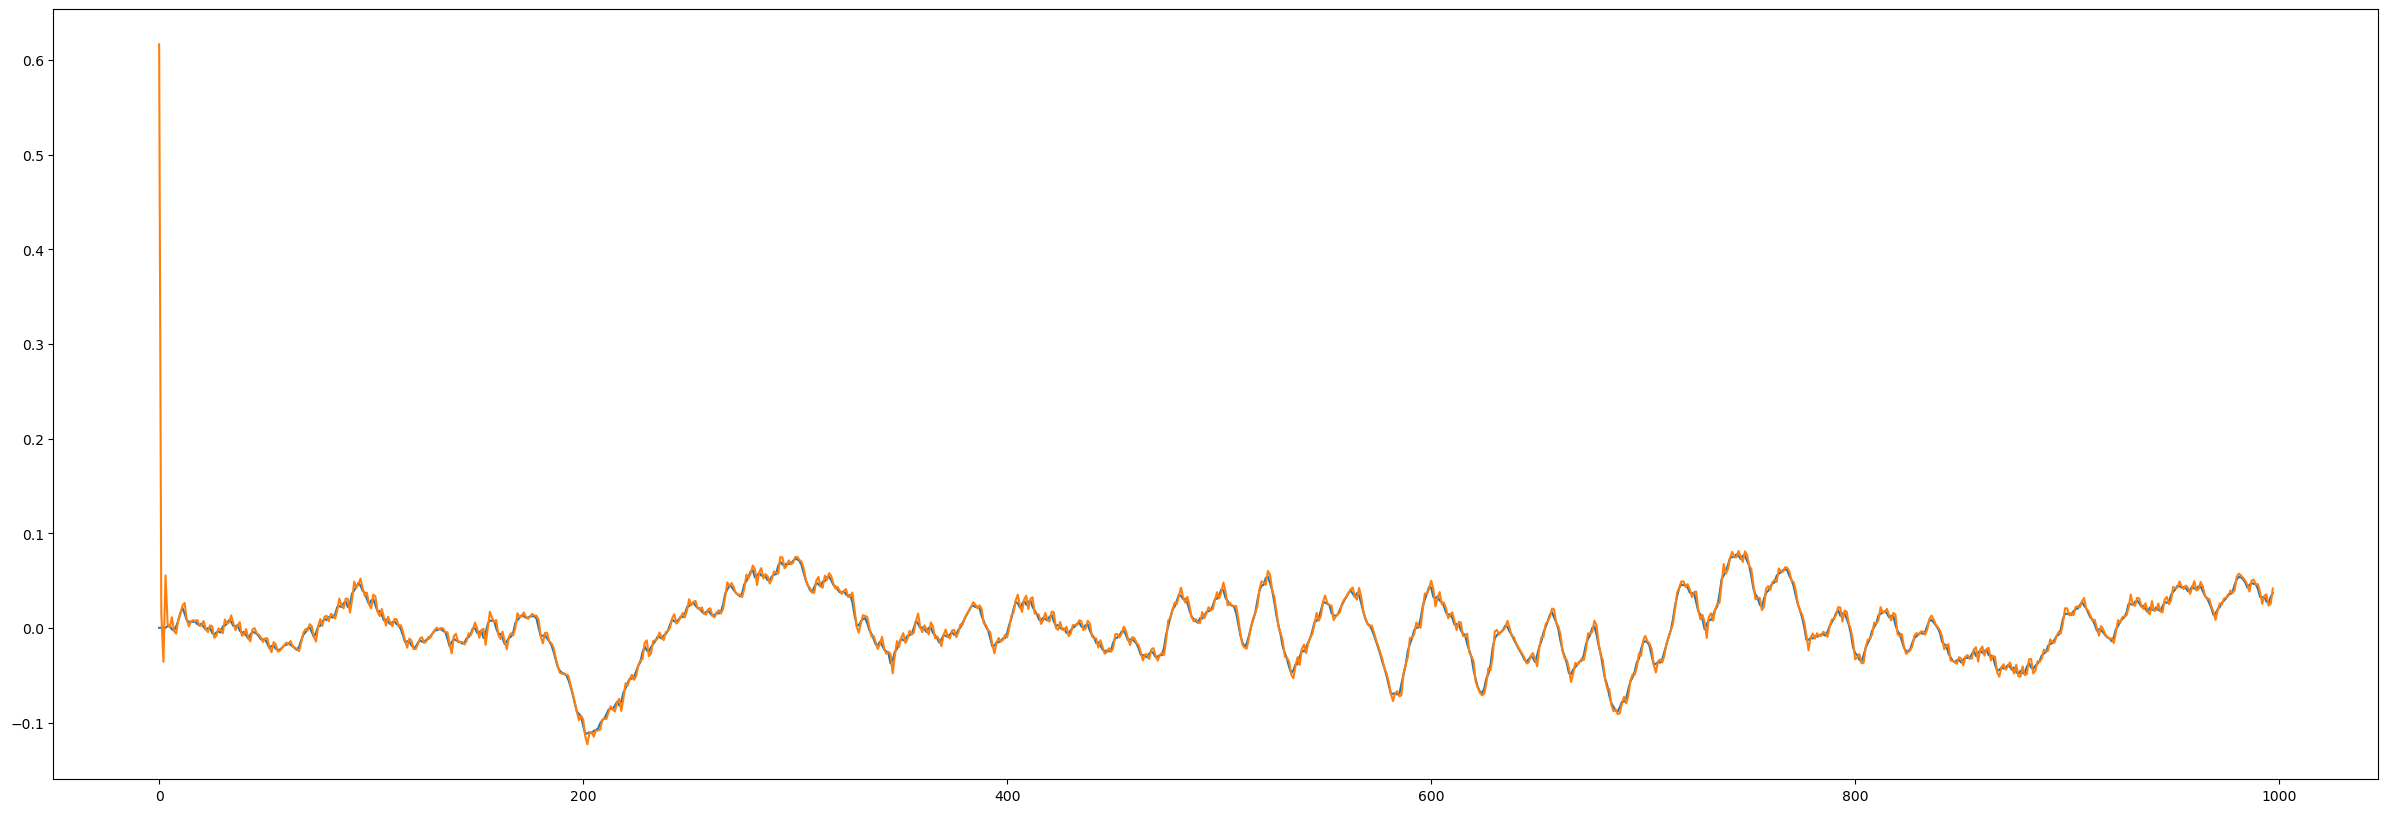

In [84]:
print("MSE of the RNN prediction after training :",np.sqrt(mean_squared_error(input[0, 1:], y[0, :-1])))
plt.figure(figsize=(30,10))
plt.plot(input[1, 1:], label='real')
plt.plot(y[1, :-1], label='prediction');

<div class="alert alert-success">
Exercise 2:

Increase the look-ahead of your model during training. Make sure to align the `target` data with the output of your model (ie, advanced by `N` timesteps). How far ahead can your model predict with good accuracy?
</div>

In [81]:
# %load solutions/2_train.py
# training step through all data
def closure():
    optimizer.zero_grad()
    hidden=rnn.init_hidden()
    out, hidden = rnn(input, hidden, future=10)
    loss = criterion(out[:, 10:-10], target[:, 10:])
    print('loss:', loss.item())
    loss.backward()
    return loss

# Long Short-Term Memory

A more complex recurrent neural network, which actually predates much of the current era of deep learning, is called the Long Short-Term Memory unit. This unit has multiple different internal states which are transformed to retain only the pertinent information.

Gers, Felix A., Jürgen Schmidhuber, and Fred Cummins. "Learning to forget: Continual prediction with LSTM." (1999): 850-855.

<img src='img/lstm.png'>

$$
i_t = \sigma(W_{xi}x_t + W_{hi}h_{t-1} + W_{ci}c_{t-1}+b_i)\\
f_t = \sigma(W_{xf}x_t + W_{hf}h_{t-1} + W_{cf}c_{t-1}+b_f)\\
c_t = f_tc_{t-1}+i_t\tanh(W_{xc}x_t + W_{hc}h_{t-1} + b_c)\\
o_t = \sigma(W_{xo}x_t + W_{ho}h_{t-1} + W_{co}c_{t-1}+b_o)\\
h_t = o_t\tanh(c_t)
$$

<div class="alert alert-success">
Exercise 3

Modify your model from part exercise 2 to use the PyTorch `LSTMCell` classes. Be aware of the multiple return values from an LSTM - the hidden state and cell state. The documentation is [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html). Compare your test prediction error against the RNN model and against the naive baseline. 

</div>

In [141]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # self.rnn1 = nn.RNNCell(input_size, hidden_size)
        self.rnn1 = nn.LSTMCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, cell, future=0):
        # predict over the different signals
        outputs = []
        for input_t in input.split(1, dim=1):
            hidden, cell = self.rnn1(input_t, (hidden, cell))
            output = self.linear(hidden)
            outputs += [output]
        for _ in range(future):  # if we should predict the future
            hidden, cell = self.rnn1(output, (hidden, cell))
            output = self.linear(hidden)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs

    def init_states(self):
        return (torch.zeros(input.size(0), self.hidden_size, dtype=torch.double),torch.zeros(input.size(0), self.hidden_size, dtype=torch.double))
        


In [137]:
# %load solutions/3_lstm.py


In [142]:
lstm = LSTM(1, n_hidden, 1).double()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(lstm.parameters(), lr=0.8)

In [143]:
# training step through all data
def closure():
    optimizer.zero_grad()
    h_t,c_t=lstm.init_states()
    out = lstm(input,h_t,c_t)
    loss = criterion(out, target)
    print('loss:', loss.item())
    loss.backward()
    return loss

In [144]:
optimizer.step(closure)

loss: 0.028505308898141596
loss: 0.0013847764323444971
loss: 0.0011392761818375642
loss: 0.0011289137626021004
loss: 0.0011282131364536245
loss: 0.0011277821815877495
loss: 0.0011266139522531017
loss: 0.0011239663520129855
loss: 0.0011177661426688688
loss: 0.0011030887656226377
loss: 0.0010655579707188403
loss: 0.0009118583091165008
loss: 0.0006435685418157126
loss: 0.0003282065916842702
loss: 0.00031159296126894527
loss: 0.00026201495277732376
loss: 0.00012499205395998542
loss: 0.00010907260738503589
loss: 0.00010771867547214431
loss: 0.00010754976749633604


tensor(0.0285, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [145]:
h_t,c_t=lstm.init_states()
with torch.no_grad():
    outputs = lstm(input,h_t,c_t)
    y = outputs.detach().numpy()

MSE of the LSTM prediction after training : 0.014012322461000058


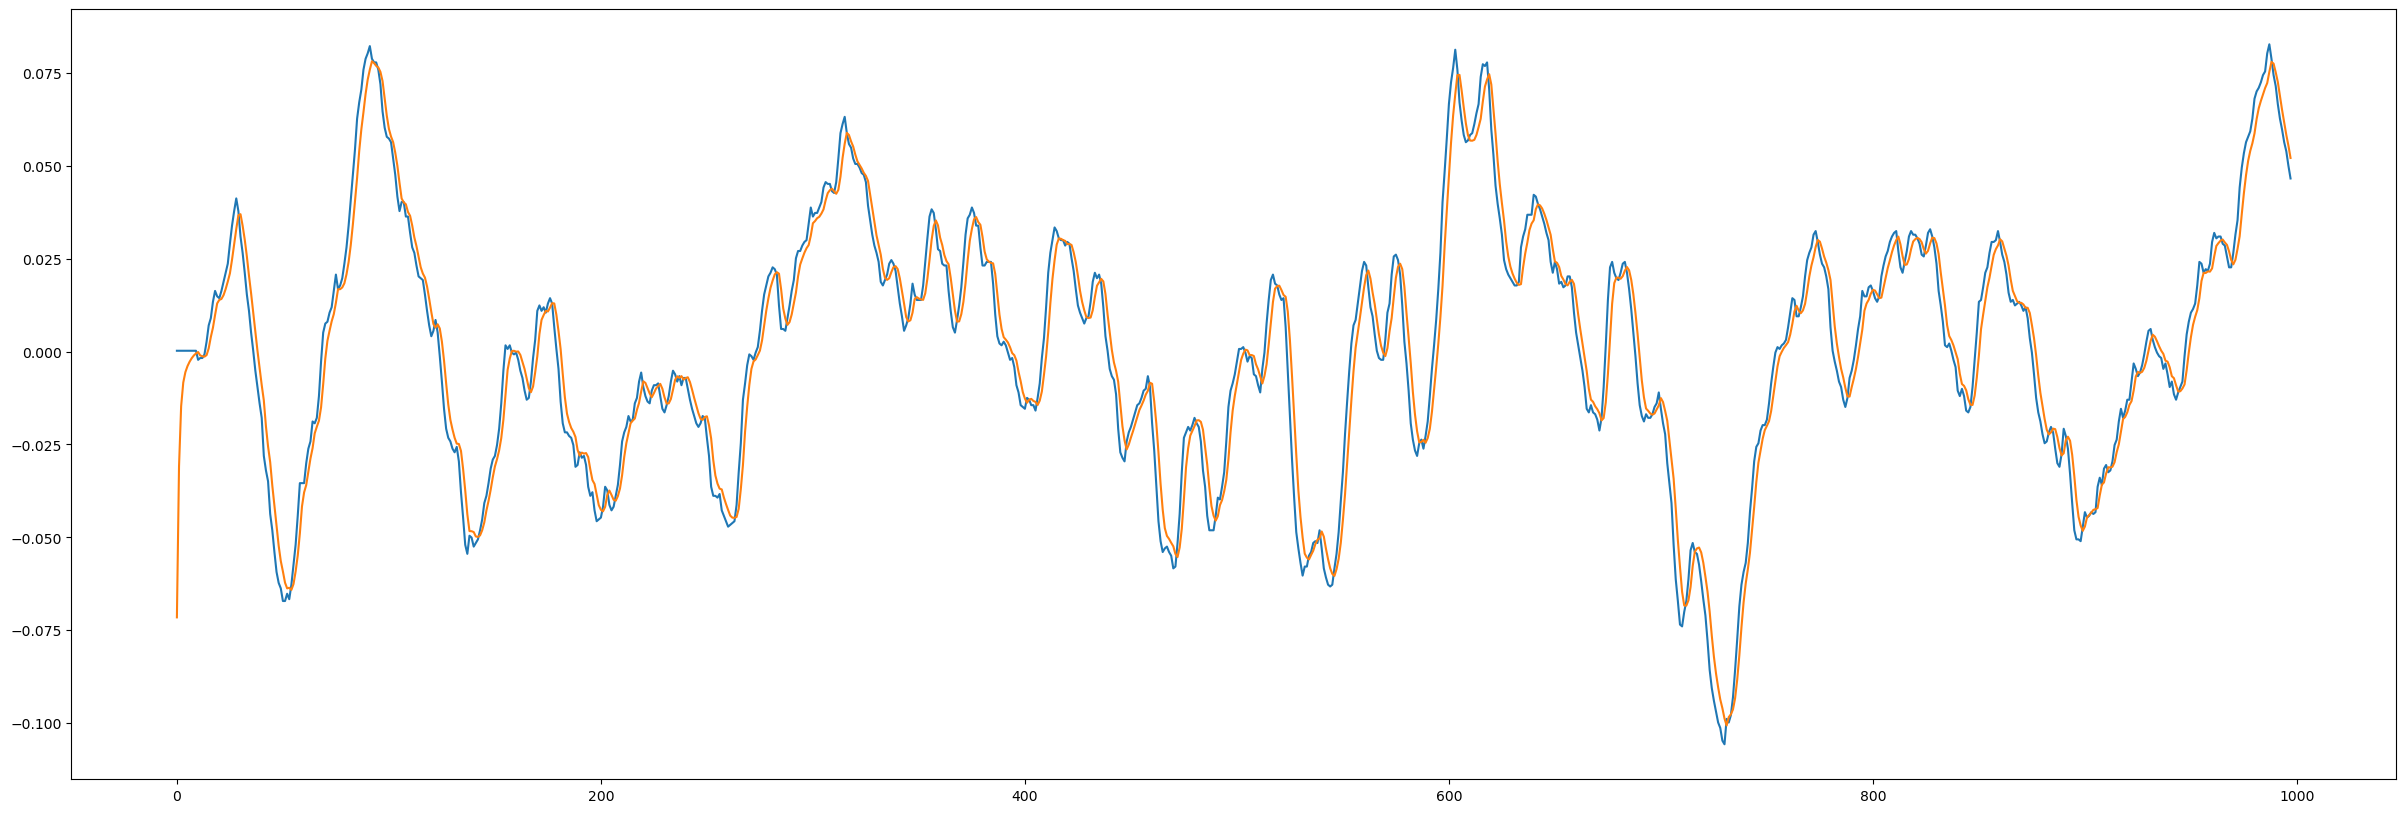

In [148]:
print("MSE of the LSTM prediction after training :",np.sqrt(mean_squared_error(input[0, 1:], y[0, :-1])))
plt.figure(figsize=(30,10))
plt.plot(input[2, 1:], label='real')
plt.plot(y[2, :-1], label='prediction');

<div class="alert alert-info">
Truncated BPTT

So far, we've been iterating through the entire dataset each epoch. In order to split the data into batches, what would need to be done? How could the hidden state of your recurrent networks be preserved between batches?
</div>

<div class="alert alert-success">
Bonus Exercise

Another recurrent layer type is the Gated Recurrent Unit. It was designed to solve the issue of vanishing gradients in LSTMs. [Here](https://arxiv.org/pdf/1412.3555.pdf) is an empirical study of the layer types. Try replacing your LSTM with a GRU to see if it changes your results.
</div>

If you'd like to know more about time-series prediction, [this notebook](https://github.com/marcopeix/stock-prediction/blob/master/Stock%20Prediction.ipynb) gives an example of more complex classical prediction models, notably Seasonal ARIMA.

In the next class, we'll see one of the most popular uses of LSTMs currently, in the context of [Natural Language Processing](https://arxiv.org/pdf/1810.04805.pdf). Before next class, please make sure you've installed `rasa`, `gensim`, and `nest-asyncio`.